# Reconocimiento de dígitos con CNN y análisis de ruido

En esta notebook, introducimos una manera de alcanzar una accuracy de validación de $99.5\%$ para la detección de dígitos manuscritos utilizando una red neuronal convolucional (CNN) construida con Keras y entrenada con el dataset MNIST.

Primero, presentamos un breve análisis de los datos que incluye balance de clases y un análisis de ruido en las imágenes. Luego, probamos diferentes arquitecturas para la red e introducimos algunas de las capas básicas utilizadas en estos casos como $\textit{Drop Out}$ y $\textit{Maxpooling}$.

## Análisis de datos

### Dataset y balance de clases

Importamos algunos módulos fundamentales:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
random_seed = 24
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

Using TensorFlow backend.


Lo primero siempre es dividir el $\textit{dataset}$ y reservar una fracción del mismo para la instancia de prueba del modelo. De esa manera, nos quedamos con $\texttt{X_test}$ y $\texttt{X_train}$. Además, guardamos las clases en una variable $\texttt{y_test}$.

In [22]:
train, X_test = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [23]:
X_train = train.drop(columns = 'label')
y_train = train.label
del train

Veamos como está ordenado nuestro dataset. Para esto imprimimos las primeras 10 instancias:

In [4]:
X_train.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cada imagen cuadrada corresponde a una fila de nuestro dataset, en la que los $28x28$ pixels fueron ordenados en una misma tira de 784 componentes. Si quisiéramos reobtener la imagen, deberíamos transformar cada fila a una matriz de $28x28$.

Para entender al tipo de problema al que nos enfrentamos, es importante estudiar el $\textbf{balance de clases}$. Un problema desbalanceado puede implicar diferentes técnicas para balancear el dataset o pesar el proceso de aprendizaje para tener en cuenta este desbalance. Además, el balance de clases es importante a la hora de elegir un score con el cuál medir el aprendizaje. Para esto, hacemos un conteo de ocurrencias de cada clase y lo volcamos a un histograma.

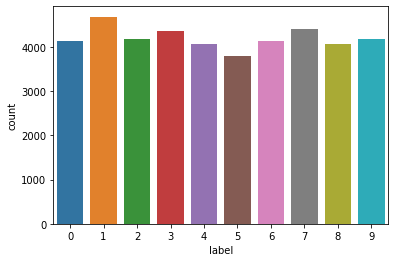

In [6]:
sns.countplot(y_train)
plt.show()

Como vemos, nuestro problema está bien balanceado. Teniendo en cuenta el tamaño del dataset, todas las clases presentan aproximadamente la misma cantidad de ocurrencias. $\textbf{Esto es bueno}$. Para empezar, no tendremos la necesidad de abordar el balance de clases con herramientas extra. Además, para un problema bien balanceado, $\textit{Accuracy}$ suele ser un buen score para realizar un seguimiento del aprendizaje. En otros casos, es conveniente prestar mayor atención a otros scores como $\textit{Recall}$, $\textit{Precition}$ o directamente $\textit{F1-score}$

### Caracterización y filtrado del ruido

A continuación, reordenamos las instancias de nuestro dataset para reobtener las imágenes originales. Esto significa convertir cada vector de $1x784$ en una matriz cuadrada de $28x28$:

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = keras.utils.to_categorical(y_train.values, 10)
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

Imprimimos el resultado:

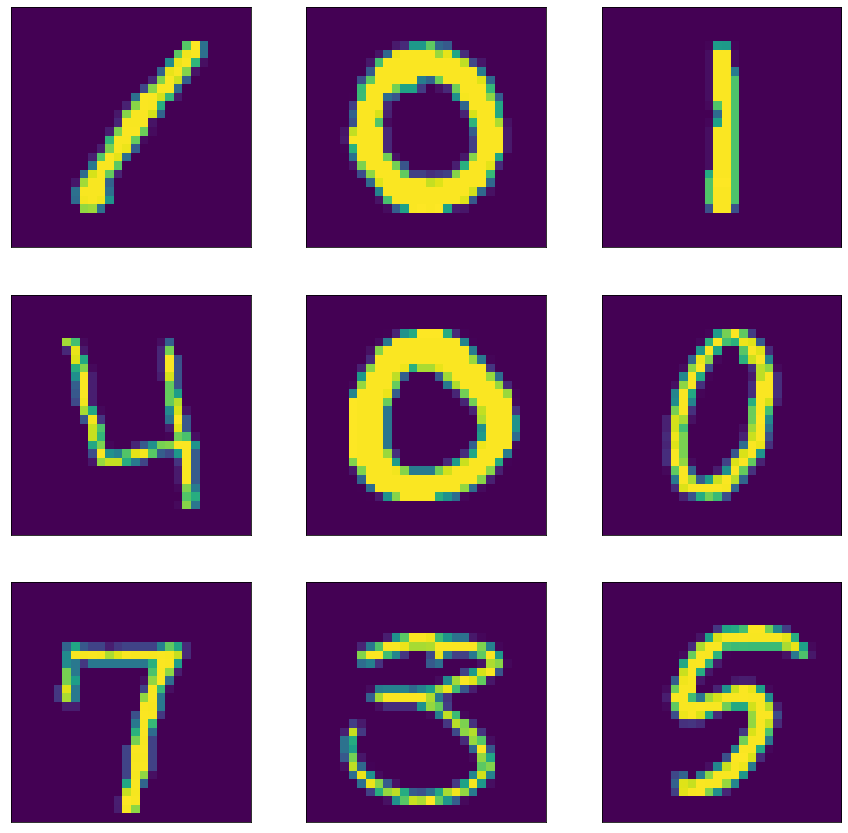

In [8]:
fig = plt.figure(figsize = (15,15))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i][:,:,0])
plt.show()

Vemos que cada instancia corresponde a un número manuscrito. Además, podemos observar a ojo que las imágenes son bastante claras y no presentan un ruido visible. A pesar de esto, es necesario realizar un estudio cuantitativo para entender mejor el ruido en nuestro dataset.

##### Ruido Gaussiano

Para empezar, hacemos un breve análisis valiéndonos del módulo $\texttt{estimate_sigma}$ proporcionado por scikit. Este, mide la desviación estándar del ruido gaussiano de una señal. Se entiende que si la distribución de la imagen presenta un $\sigma$ cercano a 0, la imagen es poco ruidosa. Por otro lado, el ruido gaussiano normal, presenta un $\sigma = 1$. Si el módulo devuelve un valor cercano a este, se entiende que la imagen se asemeja a la de una distribución normal de píxeles, entendida como $\textit{ruido gaussiano}$.

In [13]:
import skimage.data
from skimage import img_as_float
from skimage.restoration import estimate_sigma
sigma_vec = []
noise_vec = []
for imnumber in range(0,X_train.shape[0]):
    imagen = X_train[imnumber][:,:,0]
    noise = np.random.standard_normal(size = imagen.shape)
    sigma_imagen = estimate_sigma(imagen)
    sigma_noise = estimate_sigma(noise)
    sigma_vec.append(sigma_imagen)
    noise_vec.append(sigma_noise)
mean_sigma = np.mean(sigma_vec)
mean_noise = np.mean(noise_vec)
print('\n', 'La desviación estándar media de nuestro dataset es:', mean_sigma, '\n',
'La desviación estándar media de un ensamble de ruido blanco es:', mean_noise)


 La desviación estándar media de nuestro dataset es: 0.0710275309741942 
 La desviación estándar media de un ensamble de ruido blanco es: 0.9622817527794697


Podemos ver que la desviación estándar media para nuestro dataset es considerablemente menor que aquella para un ensamble de imágenes con ruido gaussiano. Esto es lógico. Podemos probar como funciona agregando ruido a una de nuestras imágenes. A continuación comparemos una imágen con y sin ruido Gaussiano.

Primero graficamos el dígito escrito a mano y el ruido gaussiano por separado.

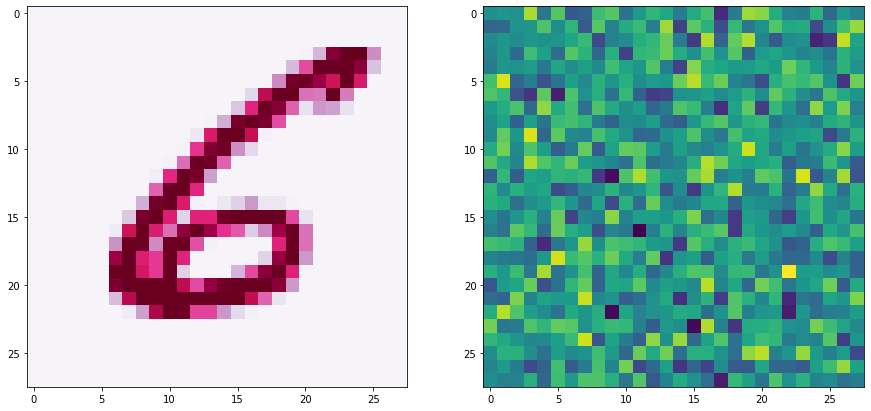

In [14]:
number = X_train[3252][:,:,0]
random_im = np.random.standard_normal(size = imagen.shape)
fig = plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(number, cmap = 'PuRd')
plt.subplot(1,2,2)
plt.imshow(random_im)

Si calculamos el sigma de cada una, obtenemos: 

In [15]:
sigma_number = estimate_sigma(number)
sigma_noise = estimate_sigma(random_im)
print('\n', 'La desviación estándar del seis es:', sigma_number, '\n',
'La desviación estándar del ruido es:', sigma_noise)


 La desviación estándar del seis es: 0.09515176442861432 
 La desviación estándar del ruido es: 0.944151171853512


Ahora, agregando ruido a nuestro dígito: 

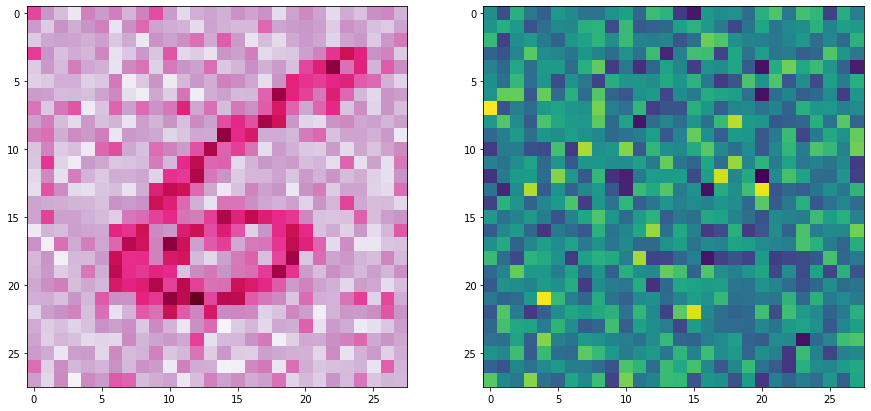

In [18]:
noise_six = X_train[3252][:,:,0] +  0.3*np.random.standard_normal(size = imagen.shape)
random_im = np.random.standard_normal(size = imagen.shape)
fig = plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(noise_number, cmap = 'PuRd')
plt.subplot(1,2,2)
plt.imshow(random_im)

Si nuestra imágen tiene ruido gaussiano, $\texttt{estimate_sigma}$ nos podría dar una buena pista:

In [19]:
sigma_noise_six = estimate_sigma(noise_six)
sigma_noise = estimate_sigma(random_im)
print('\n', 'La desviación estándar del seis es:', sigma_noise_six, '\n',
'La desviación estándar del ruido es:', sigma_noise)


 La desviación estándar del seis es: 0.3142080668290643 
 La desviación estándar del ruido es: 0.929363900682432


Podemos ver que la imagen con ruido Gaussiano tiene un sigma más cercano a 1

Si bien esta medida da una buena idea de la presencia de ruido gaussiano en una imagen, este parámetro no es determinante y un valor alto (en principio mayor a 1) podría no necesariamente deberse a ruido normal. Una vez que este estimador nos da una pista, es necesario un análisis más profundo. En nuestro caso, podemos descartar la presencia de imágenes con mucho ruido gaussiano. Sin embargo, las imágenes podrían presentar otras formas de ruido como un patrón periódico o ruido uniforme.

##### Ruido uniforme

Para estudiar el ruido uniforme en nuestros datos realizaremos un análisis estadístico. Compararemos la distribución del promedio de intensidades de cada imágen de un ensamble de imágenes con intensidad uniforme.

El $\textbf{Teorema Central del Límite}$ (TCL) establece que si una variable aleatoria $S$ es el promedio de variables aleatorias, es decir, $S =\frac {X_1+ \dots + X_n} {n}$, entonces la distribución de $S$ será aproximadamente una distribución normal para $n$ grande. Si las variables aleatorias $X_i$ tienen la misma distribución, con $\mu$ y $\sigma$, entonces la distribución de $S$ será aproximadamente ~$N(\mu,\sigma/\sqrt{n})$

Para nuestro problema podemos construir $S$ como el promedio de las intensidad de los píxeles de cada imágen, es decir, la suma de cada uno de los $784$ píxeles. Escribiendo la intensidad de cada píxel como $X_i$, $S$ se puede escribir como:

$$
\begin{equation}
S =  \frac{1}{748}\sum_i^{784}X_i
\end{equation}
$$

Veamos la distribución del promedio de intensidad de un ensamble de imágenes con intensidad uniforme. Usaremos la misma cantidad de imágenes que tiene nuestro $\textit{train set}$


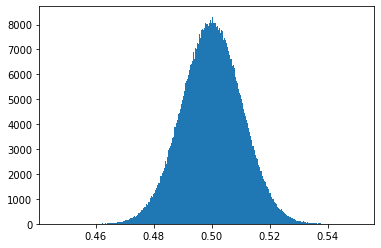

In [26]:
vec = []
for i in range(0,1000000):
    img = np.random.uniform(size = (28, 28))
    vec.append(img.mean())
plt.hist(vec, bins = 500, rwidth = 2) 
plt.show()

In [27]:
np.mean(vec) 

0.5000049919806119

In [28]:
estimate_sigma(np.array(vec))

0.01033491441872449

 El TCL también nos dice que el sigma de $S$ debe estar cerca de $\sigma/\sqrt{n}$, en nuestro caso $X_i$ vienen de una distribución uniforme ($\sigma = \frac{1}{\sqrt{12}}$), entonces then $\sigma_S$ ~ $\frac{1}{\sqrt(12)}\frac{1}{\sqrt{748}}$

Como podemos observar en la imágenes y cálculos previos, $S$ tiene una distribución aproximadamente Gaussiana. Debido a que intensidades van de $0$ to $1$ el promedio de $S$ será  $\mu = 0.5$. Ahora que sabemos cómo se comporta un ensamble de imágenes hechas de ruido uniforme, vamos a compararlo con la distribución construida a partir de nuestro dataset.  Diremos que nuestro dataset es más ruidoso cuanto más cerca esté su distribución de intensidades a la distribución del ruido .

A continuación mostramos las distribuciones de: nuestro conjunto de datos, nuestro conjunto de datos con ruido uniforme y el conjunto de ruido uniforme:

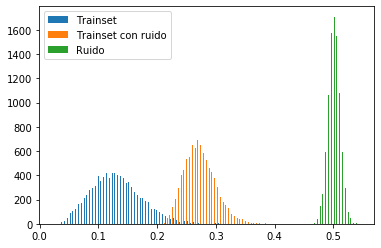

In [252]:
img_number = X_train.shape[0]
vec = []
vec2 = []
vec3 = []
for i in range(0,img_number):
    img =  X_train[i][:,:,0] 
    img = img/img.max()
    vec.append(img.mean())
    img = X_train[i][:,:,0]  + 0.6*np.random.uniform(size = (28, 28))
    img = img/img.max()
    vec2.append(img.mean())
    img = np.random.uniform(size = (28, 28))
    img = img/img.max()
    vec3.append(img.mean())
plt.hist([vec, vec2, vec3], bins = 500, rwidth = 2, label = ['Trainset', 'Trainset con ruido', 'Ruido'])
plt.legend(loc = 'upper left')
plt.show()

In [253]:
sigma_trainset =  estimate_sigma(np.array(vec))
sigma_noisy_trainset = estimate_sigma(np.array(vec2))
sigma_noise = estimate_sigma(np.array(vec3))

mean_trainset = np.mean(vec)
mean_noisy_trainset = np.mean(vec2)
mean_noise = np.mean(vec3)

print('\n', 'El sigma del trainset es:', sigma_trainset,
     '\n', 'El sigma del trainset con ruido es:', sigma_noisy_trainset,
     '\n', 'El sigma del ruido es:', sigma_noise,
     '\n', 'La media del trainset es:', mean_trainset,
     '\n', 'La media del trainset con ruido es:', mean_noisy_trainset,
     '\n', 'La media del ruido es:', mean_noise,)


 El sigma del trainset es: 0.04309035996190209 
 El sigma del trainset con ruido es: 0.026339311984114495 
 El sigma del ruido es: 0.010157342117533741 
 La media del trainset es: 0.1310661494565955 
 La media del trainset con ruido es: 0.27272880856446213 
 La media del ruido es: 0.5006280186747322


De esta manera, podemos armarnos de un set de parámetros para comparar nuestra distribución con la distribución característica del ruido uniforme. Vemos como nuestro dataset presenta una media de $\mu_{train} = 0.1$ mientras que el ruido característico $\mu_{ruido} = 0.5$. Además, se observa que la distribución del trainset con ruido agregado se posiciona, como era esperable, con una media que cae entre las anteriores dos. Por otro lado, vemos que la distribución del trainset presenta una varianza 4 veces mayor que la del ruido. Con este análisis, y para este caso en particular, podríamos concluir que nuestro dataset tampoco presenta una cantidad considerable de ruido uniforme. Sin embargo, para un análisis más concluyente, habría que pesar estos parámetros mencionados sumados a los lanzados por un ajuste gaussiano a todas las distribuciones. Un análisis del tipo $\chi^2$ podría ser útil para darnos una idea de cuán parecido es nuestro dataset a la distribución característica del ruido uniforme.

De nuevo, este sencillo análisis nos puede guiar o dar una idea de la presencia de ruido uniforme pero no es concluyente y su resultado podría inferir distintas cosas. Por ejemplo, un dataset suficientemente patológico podría resultar en una distribución gaussiana similar a la resultante de un ensamble de ruido uniforme. Con la sospecha de que nuestro dataset es poco ruidoso, nos valdremos del módulo $\texttt{ndimage}$ de $\texttt{scipy}$. Intentaremos reobtener el ruido de nuestras imágenes a partir de sustraer la información no ruidosa:


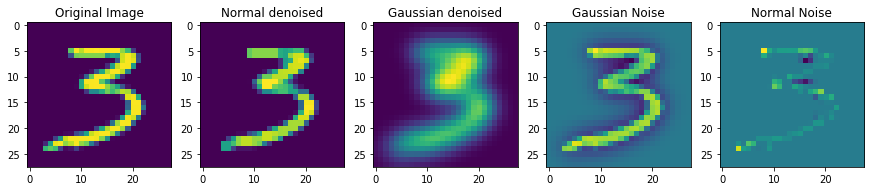

In [301]:
from scipy import ndimage

image =  X_train[25][:,:,0] 
gauss_denoised = ndimage.gaussian_filter(image, 2)
med_denoised = ndimage.median_filter(image, 3)
gauss_noise = X_train[25][:,:,0]  - gauss_denoised
med_noise = X_train[25][:,:,0]  - med_denoised

fig = plt.figure(figsize = (15,15))
plt.subplot(1,5,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,5,2)
plt.title('Normal denoised')
plt.imshow(med_denoised)
plt.subplot(1,5,3)
plt.title('Gaussian denoised')
plt.imshow(gauss_denoised)
plt.subplot(1,5,4)
plt.title('Gaussian Noise')
plt.imshow(gauss_noise)
plt.subplot(1,5,5)
plt.title('Normal Noise')
plt.imshow(med_noise)

Podemos concluir que nuestro dataset es poco ruidoso. En estos casos, hay que tener cuidado con aplicar filtros gaussianos. Si observamos la celda anterior, vemos que el resultado de haber aplicado este filtro es una imagen $\textit{blurreada}$. Partimos de una imagen nítida y poco ruidosa y obtenemos una imagen en la que se han filtrado todos los bordes claros, que han quedado en $\texttt{Gaussian Noise}$. Esto es un precio que alguien podría querer pagar si el dataset presenta una considerable cantidad de ruido. En otro caso, es recomendable no usar este tipo de filtros. Por otro lado, vemos que el resultado de sacar el ruido medio prácticamente no varía respecto de la imagen original. Esto es esperable en imágenes poco ruidosas.

##### Ruido periódico

Para tener un análisis de las fuentes más comunes de ruido también analizaremos el ruido periódico. En este caso podría servir estudiar la transformada de fourier bidimensional. Observemos lo que ocurre al sumar a una de nuestras imágenes, un patrón periódico:

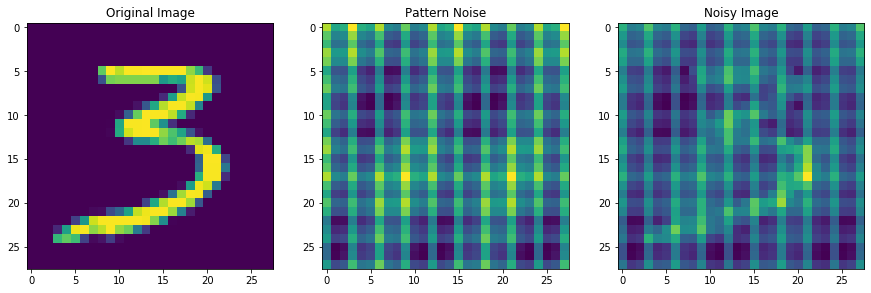

In [343]:
[X,Y] = np.meshgrid(2*np.pi * np.arange(28)/12,2*np.pi * np.arange(28)/34)
circles = np.sin(Y+X) +  np.cos(10* Y) + np.cos(2* Y) + np.cos(4* X) + np.cos(4* X)  #+ np.random.uniform(0,0.02,X.shape)
fig = plt.figure(figsize = (15,15))
image =  X_train[25][:,:,0] 
pattern_number = image + 0.3*circles
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,3,2)
plt.title('Pattern Noise')
plt.imshow(circles)
plt.subplot(1,3,3)
plt.title('Noisy Image')
plt.imshow(pattern_number)

Luego, analizamos las frecuencias de este ruido periódico a partir de la transformada de fourier de la imagen ruidosa:

Text(0.5, 1.0, 'Fourier transform')

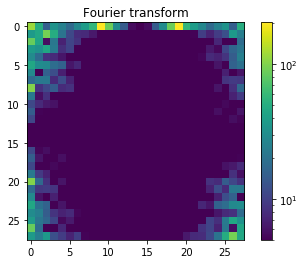

In [349]:
from scipy import fftpack
im_fft = fftpack.fft2(pattern_number)
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

Ahora, en el espacio de frecuencias, vemos los lugares de la matriz en los que se encienden modos normales. Estos modos, que se representan como picos de intensidad en el espacio de frecuencias, corresponden al ruido periódico que agregamos. Entonces, ahora que los localizamos, basta con aplicar un filtro para estos elementos de matriz:

Text(0.5, 1.0, 'Filtered Spectrum')

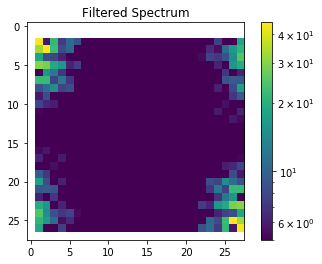

In [356]:

im_fft2 = im_fft.copy()


im_fft2[[0,1,27],:] = 0

im_fft2[:, 0:1] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Ahora calculamos la transformada inversa y vemos la imagen reobtenida:

Text(0.5, 1.0, 'Reconstructed Image')

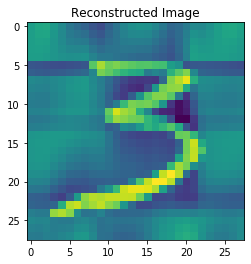

In [357]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new)
plt.title('Reconstructed Image')

¡Reobtenemos la misma imagen pero nos sacamos de encima el patrón de ruido! 

Todas la técnicas previas pueden ser usadas para filtrar los distintos tipos de ruido para obtener imágenes de mejor calidad para entrenar nuestros modelos.

### Análisis de redes neuronales convolucionales (CNN)

Finalmente, probamos algunas arquitecturas de red convolucional y discutimos algunas características. Lo primero, reservamos una fracción del 20\% del train-set para validación cruzada durante el entrenamiento: 

In [5]:
#Split train test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_seed)

A continuación definimos algunos parámetros importantes. Entre ellos, la función de activación, la función de pérdida y la métrica a mirar durante el entrenamiento. La función de activación es un operación sobre cada neurona dependiendo del $\textit{input}$. El caso básico es el de la función escalón, que prende o no la neurona dependiendo del valor de entrada. En este caso usamos $\textit{ReLU}$ o $\textit{Rectified Linear Unit}$. Esta función de activación está optimizada en especial para redes convolucionales profundas. Tiene ciertas ventajas como facilidad numérica en las operaciones algebraicas que implica y proporciona una mejor convergencia dado que minimiza los problemas por $\textit{gradient vanishing}$.

Como función de pérdida utilizamos $\textit{categorical cross entropy}$. Esta función es usual en problemas multiclase, donde se asigna como pérdida la entropía de la distribución de probabilidades de cada clase. Además, en este casos de clasificación, donde la predicción correcta es solo una, resulta útil usar esta entropía en la cual el único término no nulo de la entropía es aquel correspondiente a la clase positiva.

Por último, elegimos mirar $\textit{accuracy}$ como métrica. Resulta lo más intuitivo y fácil para problemas con buen balance de clase.


In [6]:
#CNN
#hyperparams
activation = 'relu'
#initializer = keras.initializers.lecun_uniform(seed=42)
filters = 32
kernel_size = (5,5)
init_learning_rate = 0.001

loss = 'categorical_crossentropy'
epochs = 30
dataset_size = X_train.shape[0]
batch_size = 86
metric = ['accuracy']

El algoritmo de $\texttt{ReduceLROnPlateau}$ actualiza el valor del learning rate cuando la minimización de la función de pérdida se estanca en el proceso de aprendizaje. Resulta una manera dinámica de optimizar los parámetros de la red sin tener que detener el entrenamiento. 

In [7]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)


A continuación, mostramos la estructura de la red convolucional más básica posible. Se trata de una capa de convolución 2D. Esta capa lo que hace es realizar convoluciones de la imágen con distintos filtros. En este caso, el número de filtros es $\texttt{filters = 32}$. Cada filtro se "concentra" en un aspecto particular de la imágen. Por ejemplo, un filtro se centra en las líneas horizontales, otro en las verticales y otro en las diagonales. Otro filtro puede centrarse en formas circulares, $\textit{and so on...}$ De esta manera, obtenemos una "descomposición" de 32 imágenes que guardan un aspecto particular de nuestra imagen de entrada. Los filtros están impresos en una matriz más pequeña llamada $\textit{kernel}$. En este caso $\texttt{kernel_size} = (5,5)$.

La capa de salida está conformada por $\texttt{Flatten}$ y $\texttt{Dense}$. La primera, solo convierte el input a un vector de una dimensión, como suele usarse en la salida de cualquier NN. $\texttt{Dense}$ es una capa que por definición tiene una neurona por cada $\textit{feature}$. En este caso, una por cada píxel. Esta transforma el input a la forma y dimensión deseada. En este caso, un vector de 256 elementos, uno por cada valor posible del píxel. Por último se convierte el output a una distribución de probabilidad de cada una de las $10$ clases.


In [8]:
model = Sequential()
#input layer
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation, input_shape = (28,28,1)))


#output layer
model.add(Flatten())
model.add(Dense(256, activation = activation)) #dense de 2^n
model.add(Dense( 10,activation = 'softmax'))

En la siguiente tabla podemos ver la estructura de la red:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 6,426,186
Trainable params: 6,426,186
Non-trainable params: 0
_________________________________________________________________


El algoritmo de optimización utilizado es $\texttt{RMSprop}$. Le debe su fama a su gran capacidad de convergencia, siendo considerablemente más rápido y efectivo que el resto. Además el módulo $\texttt{Keras}$ sugiere no tocar los hiperparámetros default por encontrarse optimizado para su utilización. Elegido el optimizador, entrenamos este primer modelo:

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history1 = model.fit(X_train,y_train, epochs = 6,  batch_size = batch_size, validation_data = (X_val,y_val), callbacks = [lr_reduction])

Train on 33600 samples, validate on 8400 samples
Epoch 1/6
33600/33600 [==============================] - 50s 1ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0781 - val_acc: 0.9856
Epoch 2/6
33600/33600 [==============================] - 51s 2ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0861 - val_acc: 0.9838

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/6
33600/33600 [==============================] - 51s 2ms/step - loss: 6.5489e-04 - acc: 0.9999 - val_loss: 0.0823 - val_acc: 0.9854

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/6
33600/33600 [==============================] - 50s 1ms/step - loss: 4.9125e-04 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9861
Epoch 5/6
33600/33600 [==============================] - 51s 2ms/step - loss: 4.8999e-04 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9860

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 6/6
336

Dos cosas resultan destacables del anterior entrenamiento. Lo primero es que el score obtenido es considerablemente bueno. Esto se debe a la fidelidad y tamaño del dataset. Dado este, con una red convolucional genérica como la testeada en este caso, es prácticamente inmediato obtener una $\textit{accuracy}$ de validación del $98.7\%$ si se eligen apropiadamente los hiperparámetros de la red. Sin embargo, dada la potencia de este dataset, una mejor arquitectura puede arrojar scores del $99.7\%$. Luego, una buena performance para este caso se juega en la segunda o tercera cifra significativa de la métrica en cuestión. Lo segundo destacable es que, como vemos en la diferencia entre las métricas de validación y las de entrenamiento, en este caso el entrenamiento presenta un considerable $\textit{overfitting}$. Podemos ver que la accuracy de validación es de $acc_{val} = 0.987$ mientras que la accuracy de entrenamiento arroja un $acc_{train} = 0.999$. Lo mismo indica la relación entre las funciones de pérdida.

Un buen método para contrarrestar la tendencia al overfitting es aumentar el tamaño de nuestro dataset. Para esto, podemos tomar las imágenes que tenemos y deformarlas con estiramientos y rotaciones para simular más muestras. Utilizaremos el módulo $\texttt{ImageDataGenerator}$ de Keras.


In [19]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.0, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

Luego volvemos a entrenar la misma red pero utilizando el dataset aumentado: 

In [20]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              steps_per_epoch=500, validation_data=[X_val, y_val],
                              epochs = 10,
                             callbacks=[lr_reduction])

Epoch 1/10
500/500 [==============================] - 67s 135ms/step - loss: 0.2003 - acc: 0.9445 - val_loss: 0.0416 - val_acc: 0.9852
Epoch 2/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0965 - acc: 0.9715 - val_loss: 0.0451 - val_acc: 0.9858
Epoch 3/10
500/500 [==============================] - 67s 133ms/step - loss: 0.0797 - acc: 0.9759 - val_loss: 0.0320 - val_acc: 0.9886
Epoch 4/10
500/500 [==============================] - 69s 137ms/step - loss: 0.0688 - acc: 0.9793 - val_loss: 0.0345 - val_acc: 0.9890
Epoch 5/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0618 - acc: 0.9820 - val_loss: 0.0286 - val_acc: 0.9910
Epoch 6/10
500/500 [==============================] - 66s 132ms/step - loss: 0.0563 - acc: 0.9832 - val_loss: 0.0361 - val_acc: 0.9886

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.0455 - acc: 0.9867 - val_loss

Como vemos, hemos solucionado la cuestión del overfitting. Además, al aumentar el tamaño del dataset, la performance a mejorado sustancialmente, obteniendo una accuracy de validación de $0.992$ (en una mayor cantidad de epochs puede alcanzar $0.993$). Sin embargo, sabemos que con una mejor arquitectura y valiéndonos de ciertas herramientas típicas de las redes neuronales convolucionales, este score puede mejorar sustancialmente. En particular, agregaremos dos tipos de capas que mejoran la performance de manera considerable: $\textit{Max Pooling}$ y $\textit{Drop Out}$.

Antes de probar el resultado con estas herramientas, una breve explicación del funcionamiento de cada una. $\textit{Max Pooling}$ es en algún sentido una herramienta de reducción dimensional. Recorre la imágen y se queda con el píxel de valor más grande en un grupo dado (parámetro modificable). De esta manera, luego de su aplicación resulta una imágen de dimensión menor que, teóricamente, conserva las características principales. Esto permite, por ejemplo, duplicar la cantidad de filtros de convolución sin aumentar la cantidad de neuronas. Por otro lado, $\textit{Drop Out}$ funciona como un obturador de neuronas. Anula de manera azarosa una determinada fracción de neuronas de la capa en la que se lo utilice. De esta manera, en cada acción de la capa se activan neuronas distintas evitando que se cristalicen caminos preferenciales de aprendizaje y aportando robustez a la red por distribuir uniformemente la capacidad de aprendizaje. Veamos su rendimiento:


In [22]:
model = Sequential()
#input layer
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation, input_shape = (28,28,1)))
model.add(Conv2D(filters = filters, kernel_size = kernel_size,
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 strides = 1, padding = 'Same',
                 activation =activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.15))

#output layer
model.add(Flatten())
model.add(Dense(256, activation = activation)) #dense de 2^n
model.add(Dropout(0.45))
model.add(Dense( 10,activation = 'softmax'))

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              steps_per_epoch=500, validation_data=[X_val, y_val],
                              epochs = 15,
                             callbacks=[lr_reduction])

Epoch 1/15
500/500 [==============================] - 103s 207ms/step - loss: 0.3586 - acc: 0.8849 - val_loss: 0.0477 - val_acc: 0.9836
Epoch 2/15
500/500 [==============================] - 104s 208ms/step - loss: 0.1044 - acc: 0.9691 - val_loss: 0.0345 - val_acc: 0.9887
Epoch 3/15
500/500 [==============================] - 103s 206ms/step - loss: 0.0764 - acc: 0.9773 - val_loss: 0.0412 - val_acc: 0.9861

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/15
500/500 [==============================] - 104s 207ms/step - loss: 0.0495 - acc: 0.9854 - val_loss: 0.0222 - val_acc: 0.9924
Epoch 5/15
500/500 [==============================] - 104s 208ms/step - loss: 0.0431 - acc: 0.9867 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 6/15
500/500 [==============================] - 102s 205ms/step - loss: 0.0407 - acc: 0.9876 - val_loss: 0.0191 - val_acc: 0.9945
Epoch 7/15
500/500 [==============================] - 106s 212ms/step - loss: 0.0396 - acc: 0.9880 - v

Como vemos, la performance ha mejorado sustancialmente alcanzando los valores esperados. En este caso se muestra un entrenamiento de pocas iteraciones. El rendimiento puede incluso mejorar con una cantidad mayor de epochs.

En resumen, las redes neuronales convolucionales son particularmente preferidas para detección, reconocimiento o clasificación de imágenes. En este artículo se han presentado nociones y estructuras básicas de este tipo de redes para la clasificación de un dataset "de juguete". En un caso más realista con imágenes ruidosas y de mayor tamaño, será necesario un análisis más exhaustivo de la configuración de parámetros y especies y cantidad de capas para alcanzar buenos resultados. Además, el pre-procesamiento de los datos resulta crucial para explotar la potencia de este tipo de modelos.